In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch
import seaborn as sns

from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Przygotowywanie danych
Załadujemy zbiór danych MNIST i wydzielimy ze zbioru treningowego zbiór walidacyjny. Podajemy też funkcje do ewaluacji z poprzedniego notebooka.

In [2]:
mnist_train_and_val = MNIST(".", train=True, download=True, transform=ToTensor())
mnist_train = Subset(mnist_train_and_val, list(range(50000)))
mnist_val = Subset(mnist_train_and_val, list(range(50000, 60000)))
mnist_test = MNIST(".", train=False, download=True, transform=ToTensor())


@torch.no_grad()
def evaluate_fullgd(model, x, y):
    # Full batch version
    total_num = 0
    correct_num = 0

    preds = model(x)
    correct_num += (y == preds.argmax(-1)).float().sum().item()
    total_num += len(y)
    return correct_num / total_num

/home/wolczyk/miniconda3/envs/pytorch1.9/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630797748/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# SGD z regularyzacją

In [3]:
def train_regularization(epochs_num, reg_coef):
    model = nn.Sequential(
        nn.Linear(784, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
    )
    model = model.cuda()

    train_loader = DataLoader(
        mnist_train,
        batch_size=128,
        pin_memory=True,
        num_workers=4,
    )
    val_loader = DataLoader(mnist_val, batch_size=50000, shuffle=False)
    x_val, y_val = next(iter(val_loader))
    x_val = x_val.cuda().view(-1, 784)
    y_val = y_val.cuda()

    # Dodajemy regularyzację do optymalizatora.
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=reg_coef
    )
    loss_fn = nn.CrossEntropyLoss()

    train_accs = []
    train_losses = []
    val_accs = []

    for epoch in range(epochs_num):
        epoch_loss = []
        correct_num = 0
        total_num = 0
        for x, y in train_loader:
            x = x.cuda().view(-1, 784)
            y = y.cuda()
            preds = model(x)
            loss_val = loss_fn(preds, y)
            loss_val.backward()
            epoch_loss += [loss_val.item()]
            optimizer.step()
            optimizer.zero_grad()
            correct_num += (preds.argmax(-1) == y).float().sum().item()
            total_num += len(x)
        train_accs += [correct_num / total_num]
        train_losses += [np.mean(epoch_loss)]

        val_acc = evaluate_fullgd(model, x_val, y_val)
        if epoch % 100 == 0:
            print(
                f"Epoch {epoch}, train loss: {np.mean(epoch_loss)}, val acc: {val_acc}"
            )
        val_accs += [val_acc]
    return train_losses, val_accs

In [4]:
reg_list = [0.0, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

reg_results = {}
for reg in reg_list:
    print("=" * 5, reg, "=" * 5)
    reg_results[reg] = train_regularization(500, reg)

===== 0.0 =====
Epoch 0, train loss: 0.4969801064151937, val acc: 0.9499
Epoch 100, train loss: 3.437234700550267e-06, val acc: 0.9806
Epoch 200, train loss: 1.2245290001574148e-06, val acc: 0.9809
Epoch 300, train loss: 7.394765291129426e-07, val acc: 0.981
Epoch 400, train loss: 5.263250083854898e-07, val acc: 0.9811
===== 1e-06 =====
Epoch 0, train loss: 0.4946900713817238, val acc: 0.9463
Epoch 100, train loss: 5.451837326766343e-06, val acc: 0.9821
Epoch 200, train loss: 3.5011934908369786e-06, val acc: 0.9818
Epoch 300, train loss: 3.504926262182765e-06, val acc: 0.982
Epoch 400, train loss: 3.755506968498725e-06, val acc: 0.9824
===== 5e-06 =====
Epoch 0, train loss: 0.4805491420123583, val acc: 0.9484
Epoch 100, train loss: 1.862075126383278e-05, val acc: 0.983
Epoch 200, train loss: 2.7753996846240888e-05, val acc: 0.9826
Epoch 300, train loss: 3.684164403966163e-05, val acc: 0.9823
Epoch 400, train loss: 4.354827342525767e-05, val acc: 0.9818
===== 1e-05 =====
Epoch 0, train 

Reg. 0.0 0.9825
Reg. 1e-06 0.9828
Reg. 5e-06 0.9831
Reg. 1e-05 0.9825
Reg. 5e-05 0.9849


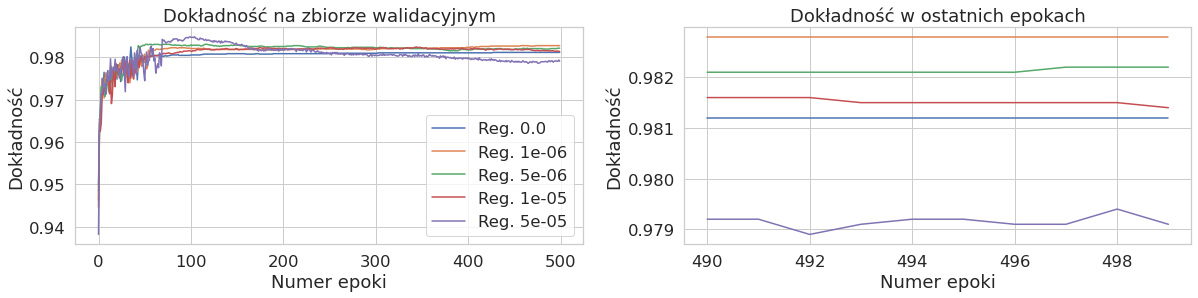

In [5]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

fig, (acc_ax, zoomed_acc_ax) = plt.subplots(1, 2, figsize=(20, 4))

acc_ax.set_title("Dokładność na zbiorze walidacyjnym")
acc_ax.set_xlabel("Numer epoki")
acc_ax.set_ylabel("Dokładność")

zoomed_acc_ax.set_title("Dokładność w ostatnich epokach")
zoomed_acc_ax.set_xlabel("Numer epoki")
zoomed_acc_ax.set_ylabel("Dokładność")


for reg, (losses, accs) in reg_results.items():
    if reg >= 0.0001:
        continue
    name = f"Reg. {reg}"
    acc_ax.plot(accs, label=name)
    zoomed_acc_ax.plot(np.arange(490, 500), accs[-10:], label=name)

    acc_ax.legend()
    print(name, max(accs))

# Early stopping

Reg. 0.0 0.9825
Reg. 1e-06 0.9828
Reg. 5e-06 0.9831
Reg. 1e-05 0.9825
Reg. 5e-05 0.9849


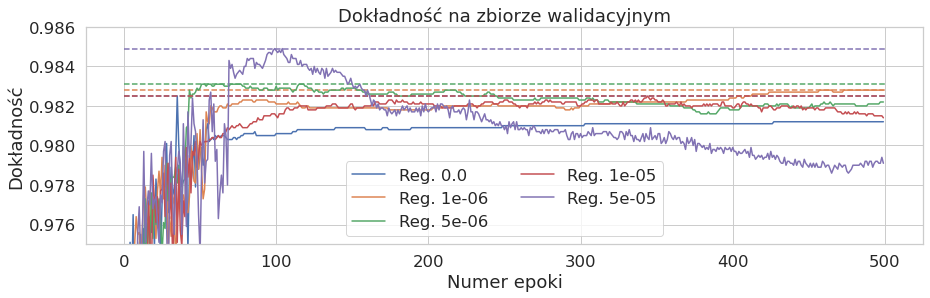

In [6]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

fig, acc_ax = plt.subplots(1, 1, figsize=(15, 4))

acc_ax.set_title("Dokładność na zbiorze walidacyjnym")
acc_ax.set_xlabel("Numer epoki")
acc_ax.set_ylabel("Dokładność")


for reg, (losses, accs) in reg_results.items():
    if reg >= 0.0001:
        continue
    name = f"Reg. {reg}"

    color = next(acc_ax._get_lines.prop_cycler)["color"]
    acc_ax.set_ylim(0.975, 0.986)
    acc_ax.plot(accs, label=name, color=color)
    max_value = max(accs)
    acc_ax.plot([0, 500], [max_value, max_value], "--", color=color)

    acc_ax.legend(ncol=2)
    print(name, max_value)

# Augmentacje

0.0 0.0


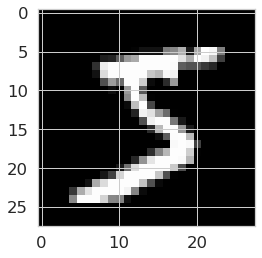

1 0.0


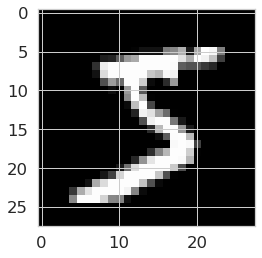

5 0.0


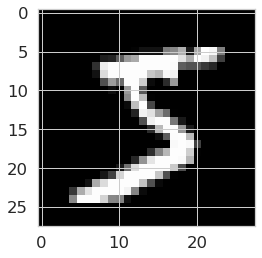

10 0.0


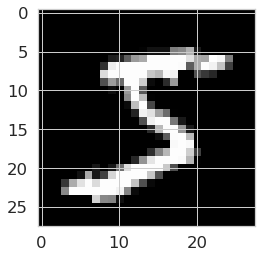

30 0.0


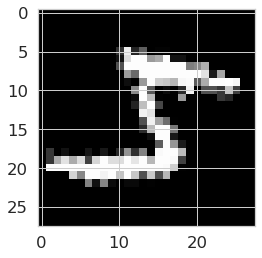

45 0.0


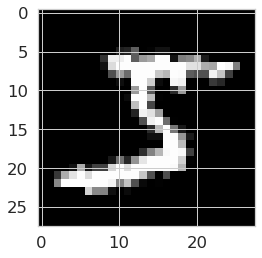

60 0.0


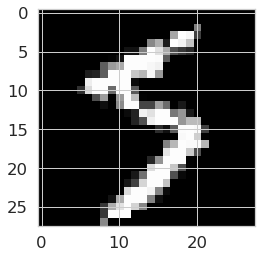

In [7]:
for rot_degree in [0.0, 1, 5, 10, 30, 45, 60]:
    for translate in [
        0.0,
    ]:
        print(rot_degree, translate)
        data_transforms = transforms.Compose(
            [
                transforms.RandomAffine(rot_degree, translate=(translate, translate)),
                transforms.ToTensor(),
            ]
        )

        augmented_mnist_train_and_val = MNIST(
            ".", train=True, download=True, transform=data_transforms
        )
        plt.imshow(augmented_mnist_train_and_val[0][0].reshape(28, 28), cmap="gray")
        plt.show()

In [17]:
def train_augmentation(epochs_num, lr, measure_test_acc=False):
    model = nn.Sequential(
        nn.Linear(784, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
    )
    model = model.cuda()

    train_loader = DataLoader(
        augmented_mnist_train,
        batch_size=128,
        pin_memory=True,
        num_workers=4,
    )
    val_loader = DataLoader(mnist_val, batch_size=50000, shuffle=False)
    x_val, y_val = next(iter(val_loader))
    x_val = x_val.cuda().view(-1, 784)
    y_val = y_val.cuda()

    test_loader = DataLoader(mnist_test, batch_size=50000, shuffle=False)
    x_test, y_test = next(iter(test_loader))
    x_test = x_test.cuda().view(-1, 784)
    y_test = y_test.cuda()

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()

    train_accs = []
    train_losses = []
    val_accs = []
    if measure_test_acc:
        test_accs = []
    else:
        test_accs = None

    for epoch in range(epochs_num):
        epoch_loss = []
        correct_num = 0
        total_num = 0
        for x, y in train_loader:
            x = x.cuda().view(-1, 784)
            y = y.cuda()
            preds = model(x)
            loss_val = loss_fn(preds, y)
            loss_val.backward()
            epoch_loss += [loss_val.item()]
            optimizer.step()
            optimizer.zero_grad()
            correct_num += (preds.argmax(-1) == y).float().sum().item()
            total_num += len(x)
        train_accs += [correct_num / total_num]
        train_losses += [np.mean(epoch_loss)]

        val_acc = evaluate_fullgd(model, x_val, y_val)
        val_accs += [val_acc]
            
        if measure_test_acc:
            test_acc = evaluate_fullgd(model, x_test, y_test)
            test_accs += [test_acc]
            
        if epoch % 100 == 0:
            log_str = f"Epoch {epoch}, train loss: {np.mean(epoch_loss)}, val acc: {val_acc}"
            if measure_test_acc:
                log_str += f", test acc: {test_acc}"
            print(log_str)
    return train_losses, val_accs, test_accs

In [18]:
aug_results = {}
for rot_degree in [0.0, 15, 30]:
    for translate in [0.0, 0.1]:
        print(rot_degree, translate)
        data_transforms = transforms.Compose(
            [
                transforms.RandomAffine(rot_degree, translate=(translate, translate)),
                transforms.ToTensor(),
            ]
        )

        augmented_mnist_train_and_val = MNIST(
            ".", train=True, download=True, transform=data_transforms
        )
        augmented_mnist_train = Subset(
            augmented_mnist_train_and_val, list(range(50000))
        )

        aug_results[(rot_degree, translate)] = train_augmentation(500, 0.05)

0.0 0.0
Epoch 0, train loss: 0.5882444997577716, val acc: 0.9496
Epoch 100, train loss: 6.92228246195976e-06, val acc: 0.9819
Epoch 200, train loss: 3.007873233617439e-06, val acc: 0.982
Epoch 300, train loss: 1.9216030516388154e-06, val acc: 0.9823
Epoch 400, train loss: 1.4070725045055409e-06, val acc: 0.9823
0.0 0.1
Epoch 0, train loss: 0.9756830359435142, val acc: 0.929
Epoch 100, train loss: 0.032564953842666, val acc: 0.9851
Epoch 200, train loss: 0.023591966100908426, val acc: 0.9884
Epoch 300, train loss: 0.021185115831496213, val acc: 0.9869
Epoch 400, train loss: 0.021510549482664756, val acc: 0.9871
15 0.0
Epoch 0, train loss: 0.6717705679366656, val acc: 0.9385
Epoch 100, train loss: 0.007569116499614334, val acc: 0.9837
Epoch 200, train loss: 0.0032206440245093467, val acc: 0.9867
Epoch 300, train loss: 0.001961451178153982, val acc: 0.9855
Epoch 400, train loss: 0.0020453077029589607, val acc: 0.986
15 0.1
Epoch 0, train loss: 1.0368218613250175, val acc: 0.9269
Epoch 100

Rot. 0.0, Trans. 0.0, Final accuracy: 0.9823
Rot. 0.0, Trans. 0.1, Final accuracy: 0.9888
Rot. 15, Trans. 0.0, Final accuracy: 0.9864
Rot. 15, Trans. 0.1, Final accuracy: 0.9898
Rot. 30, Trans. 0.0, Final accuracy: 0.9839
Rot. 30, Trans. 0.1, Final accuracy: 0.9881


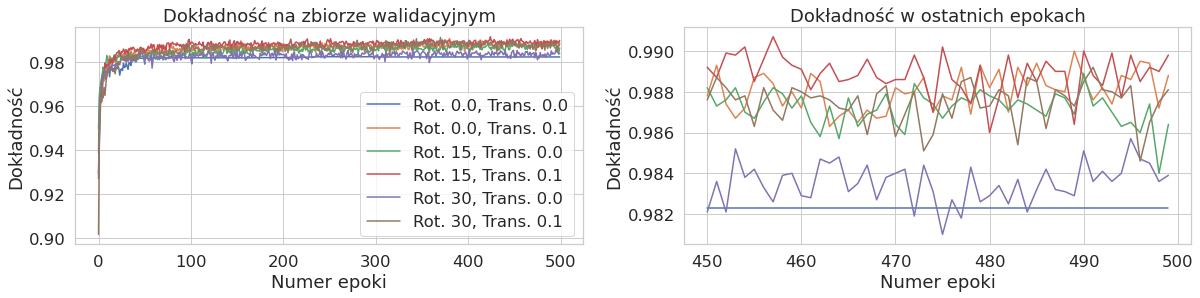

In [20]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

fig, (acc_ax, zoomed_acc_ax) = plt.subplots(1, 2, figsize=(20, 4))

acc_ax.set_title("Dokładność na zbiorze walidacyjnym")
acc_ax.set_xlabel("Numer epoki")
acc_ax.set_ylabel("Dokładność")

zoomed_acc_ax.set_title("Dokładność w ostatnich epokach")
zoomed_acc_ax.set_xlabel("Numer epoki")
zoomed_acc_ax.set_ylabel("Dokładność")


for (rot_degree, translate), (losses, accs, _) in aug_results.items():

    name = f"Rot. {rot_degree}, Trans. {translate}"
    acc_ax.plot(accs, label=name)

    zoomed_acc_ax.plot(np.arange(450, 500), accs[-50:], label=name)
    acc_ax.legend(ncol=1)
    print(f"{name}, Final accuracy: {accs[-1]}")

# Trenowanie finalnego modelu 

Po dobraniu hiperparametrów możemy sprawdzić wynik na zbiorze testowym.

In [21]:
data_transforms = transforms.Compose(
    [
        transforms.RandomAffine(15, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ]
)

augmented_mnist_train_and_val = MNIST(
    ".", train=True, download=True, transform=data_transforms
)
augmented_mnist_train = Subset(augmented_mnist_train_and_val, list(range(50000)))

final_results = train_augmentation(500, 0.05, True)

Epoch 0, train loss: 1.0086676033637714, val acc: 0.9236, test acc: 0.9162
Epoch 100, train loss: 0.05543335746911823, val acc: 0.9874, test acc: 0.9869
Epoch 200, train loss: 0.050319778355722176, val acc: 0.9885, test acc: 0.99
Epoch 300, train loss: 0.04577123537145155, val acc: 0.989, test acc: 0.9894
Epoch 400, train loss: 0.04271557411614239, val acc: 0.9886, test acc: 0.989
